# Занятие 1: Линейная и Полиномиальная Регресия

## Загружаем библиотеки

In [2]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

## Класический пример из sklearn

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


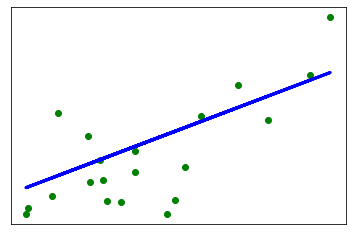

In [3]:
# Code source: Jaques Grobler
# License: BSD 3 clause
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]


# Добавим outlier
# diabetes_X_train[-1] = 1.5
# diabetes_y_train[-1] = 1


# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))

# The coefficient of determination: 1 is perfect prediction
# https://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
#plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='green')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Загружаем и анализируем датасет о использовании електричества

### Потребление Электричества

In [4]:
date_start = '2008-01-01'
date_end = '2019-05-18'
area = 'STH'
url_base = 'https://mimer.svk.se/'
url_target = 'ConsumptionProfile/DownloadText?groupByType=0&' + \
             'periodFrom='+date_start+'&' + \
             'periodTo='+date_end+'&' + \
             'networkAreaIdString='+area

In [5]:
url = url_base+url_target
df_load = pd.read_csv(url, sep=';', header=1, decimal=',', usecols=[0,1], names=['Datetime', 'Load'])
df_load = df_load[:-1]
df_load.index = pd.to_datetime(df_load['Datetime'])
df_load = df_load.drop(columns='Datetime')
df_load['Load'] = -df_load['Load']/10**3

### Температура воздуха 

In [6]:
location = ('Stockholm A', 98230)
url = 'http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/1/station/' + str(location[1]) + '/period/corrected-archive/data.csv'
r = requests.get(url)
decoded_content = r.content.decode('utf-8')
data = list(csv.reader(decoded_content.splitlines(), delimiter=';'))

In [7]:
header = 10
datetime = []
values = []
for d in data[header:]:
    datetime.append(d[0]+' '+d[1])
    values.append(float(d[2]))
df_temp = pd.DataFrame(data=values, index=pd.to_datetime(datetime), columns=['Temperature'])

### Объединяем и сокрощаем

In [8]:
df = pd.concat([df_load, df_temp*10], axis=1).dropna()
df = df['2010':]

### Визуализируем данные

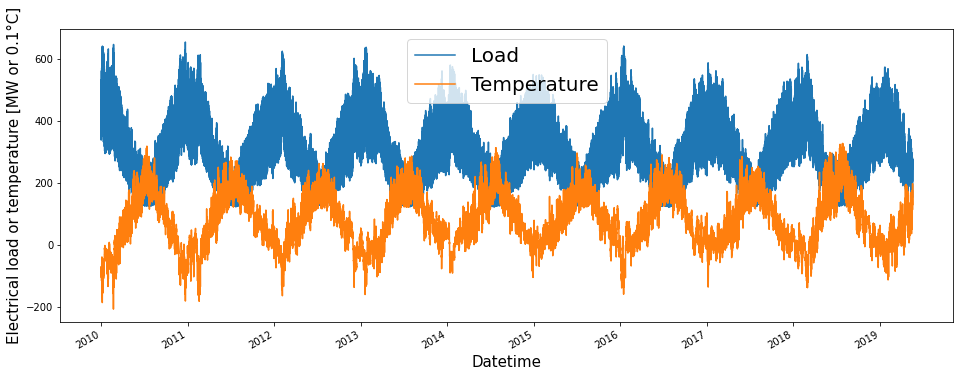

In [9]:
df.plot(figsize=(16,6))
plt.xlabel('Datetime', fontsize=15)
plt.ylabel('Electrical load or temperature [MW or 0.1°C]', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


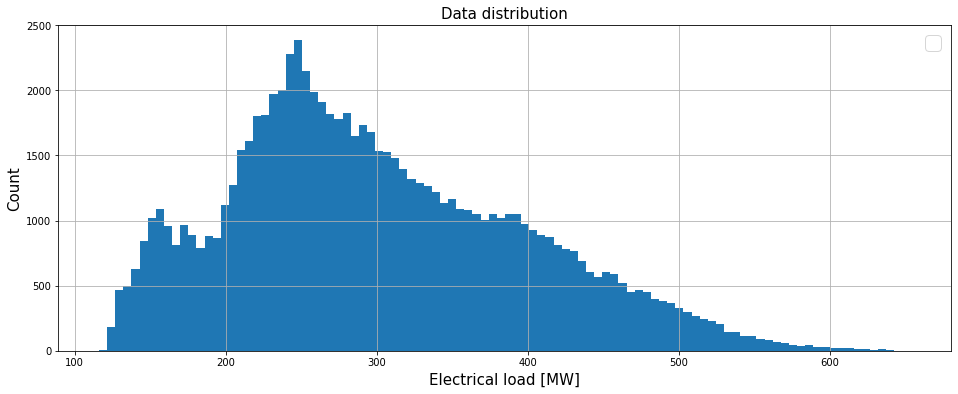

In [10]:
df['Load'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Electrical load [MW]', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


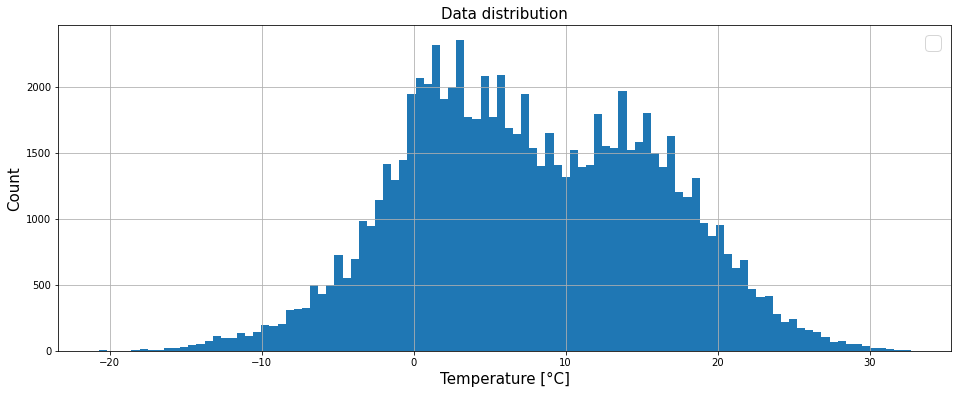

In [11]:
df['Temperature'] = df['Temperature'] / 10  # убираем множитель
df['Temperature'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

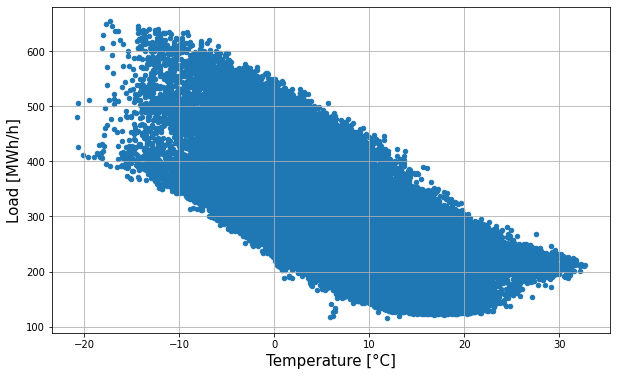

In [12]:
df.plot.scatter('Temperature', 'Load', figsize=(10,6))
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Load [MWh/h]', fontsize=15)
plt.grid()

## Разделяем дата на выборки

In [13]:
x_data = np.expand_dims(df['Temperature'].values, axis=1)
y_data = np.expand_dims(df['Load'].values, axis=1)

# 20% данных будем использовать как validation dataset
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 65432.
Data points in val set: 16358.
Shape of features in training data: (65432, 1)
Shape of output in training data: (65432, 1)
Shape of features in val data: (16358, 1)
Shape of output in val data: (16358, 1)


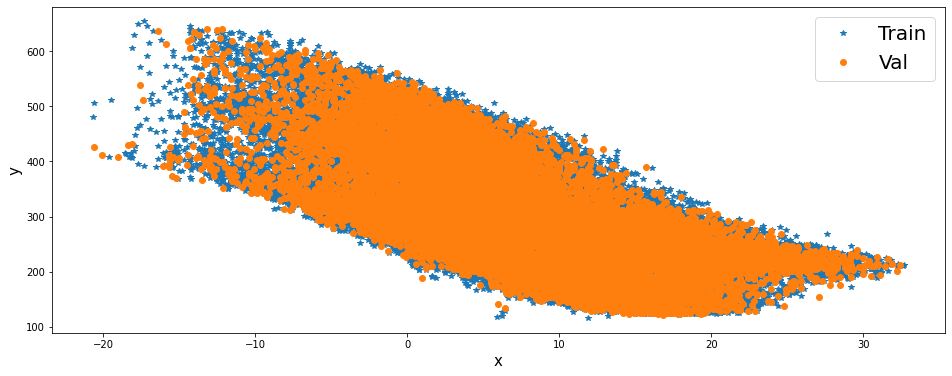

In [14]:
# Посмотрить показательный ли validation dataset
plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_val, y_val, 'o', label='Val')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Применяем линейную регресию

In [15]:
reg = LinearRegression().fit(X_train, y_train)

# Считаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print("Regression R2 score on the train data: ", reg.score(X_train, y_train))
print("Regression R2 score on the val data: ", reg.score(X_val, y_val))

Regression R2 score on the train data:  0.4701980439548211
Regression R2 score on the val data:  0.471377079070752


NameError: name 'load_y_pred' is not defined

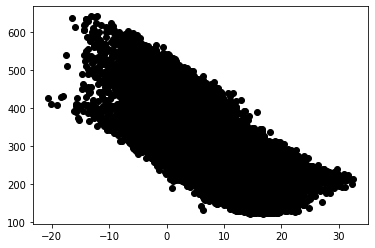

In [16]:
# Визуализируем
plt.scatter(X_val, y_val,  color='black')
plt.scatter(X_val, load_y_pred, color='blue', linewidth=3)

plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Load [MWh/h]', fontsize=15)

plt.show()

## Применяем полиномиальную регресию

Coefficient of determination: 0.47


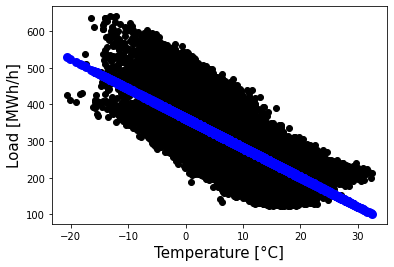

In [17]:
# Задаем степень полинома
polynomial_degree = 1

# Описиваем полиновиальную регресию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, ploy_load_pred))

# Визуализируем
plt.scatter(X_val, y_val,  color='black')
plt.scatter(X_val, ploy_load_pred, color='blue', linewidth=3)

plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Load [MWh/h]', fontsize=15)

plt.show()

In [ ]:
# На этом сегодня все